# 1. Introduction
I was looking at [NBA stats](https://www.nba.com/stats/players/) then realized that there are so many players I have never heard of.<br>
So, I decided to look for future NBA superstars based on their efficiency, points and position info.<br>
**If you're reading this, please upvote.**

In [1]:
# libraries
import random
import pandas as pd
import numpy as np
import seaborn as sns
import networkx as nx
import datetime
import fuzzywuzzy
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import warnings; warnings.filterwarnings("ignore")

# unhide all rows and columns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

# for character encoding
import chardet

# for box-cox transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# 2. Data Loading
The following lines prevent some errors while loading data, delete them from the code and check for yourselves:
* encoding="latin-1"
* delimiter=";"

Dataset is ranked alphabetically so I indexed the "Rk" column.

In [2]:
# load data
nba = "../input/nba-player-stats/2021-2022 NBA Player Stats.csv"
players = pd.read_csv(nba, delimiter=";", encoding="latin-1", index_col=0)
players.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Rk,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Precious Achiuwa,C,22,TOR,34,20,25.3,3.4,8.1,0.412,0.3,1.3,0.233,3.1,6.9,0.444,0.430,0.9,1.6,0.574,2.4,5.3,7.7,1.3,0.6,0.6,1.1,2.2,7.9
2,Steven Adams,C,28,MEM,44,43,25.7,2.6,4.9,0.521,0.0,0.0,0.000,2.6,4.9,0.521,0.521,1.6,2.8,0.566,4.3,4.9,9.3,3.0,1.0,0.6,1.6,1.7,6.7
3,Bam Adebayo,C,24,MIA,21,21,32.9,6.9,13.3,0.518,0.0,0.0,0.000,6.9,13.3,0.520,0.518,4.9,6.3,0.767,2.6,7.3,10.0,3.2,1.2,0.5,2.9,3.1,18.7
4,Santi Aldama,PF,21,MEM,25,0,10.5,1.4,3.8,0.372,0.2,1.5,0.105,1.2,2.2,0.554,0.394,0.4,0.8,0.579,0.9,1.6,2.5,0.5,0.1,0.2,0.3,0.9,3.4
5,LaMarcus Aldridge,C,36,BRK,32,10,23.1,5.9,10.3,0.574,0.4,1.1,0.333,5.6,9.2,0.603,0.592,1.6,1.8,0.862,1.5,4.1,5.7,0.9,0.4,1.1,0.8,1.7,13.8
6,Nickeil Alexander-Walker,SG,23,NOP,42,18,26.5,4.7,12.8,0.370,2.0,6.2,0.313,2.8,6.6,0.424,0.446,1.2,1.7,0.704,0.8,2.6,3.4,2.6,0.8,0.3,1.6,1.8,12.6
7,Grayson Allen,SG,26,MIL,41,40,28.1,4.1,9.6,0.423,2.6,6.7,0.391,1.5,3.0,0.496,0.558,1.0,1.2,0.857,0.5,2.9,3.4,1.3,0.8,0.4,0.6,1.5,11.8
8,Jarrett Allen,C,23,CLE,39,39,32.7,6.7,9.6,0.695,0.0,0.2,0.125,6.6,9.4,0.708,0.697,2.9,4.2,0.697,3.3,7.6,10.9,1.8,0.8,1.4,1.9,1.8,16.3
9,Jose Alvarado,PG,23,NOP,18,0,9.2,1.1,3.1,0.364,0.4,1.4,0.269,0.7,1.6,0.448,0.427,0.5,0.8,0.643,0.3,0.7,1.0,1.6,1.0,0.1,0.2,1.0,3.1


# 3. Data Cleaning
Have a look at the column names. They usually become useful later on.

In [3]:
players.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], dtype='object')

Check for missing values.

In [4]:
# get the number of missing data points per column
missing_values_count = players.isnull().sum()

# look at the number of missing points in the columns
missing_values_count[:]

Player    0
Pos       0
Age       0
Tm        0
G         0
GS        0
MP        0
FG        0
FGA       0
FG%       0
3P        0
3PA       0
3P%       0
2P        0
2PA       0
2P%       0
eFG%      0
FT        0
FTA       0
FT%       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
dtype: int64

Great dataset with no missing values! Don't mind giving [the dataset](https://www.kaggle.com/vivovinco/nba-player-stats) an upvote!

# 3. Adding Information
Calculate efficiency and add as a column.<br>
Efficiency (EFF) = (PTS + REB + AST + STL + BLK – Missed FG – Missed FT – TOV)

In [5]:
Efficiency = players.PTS + players.TRB + players.AST + players.STL + players.BLK - (players.FGA - players.FG) - (players.FTA - players.FT) - players.TOV
players.insert(29, "EFF", Efficiency)
players.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,EFF
Rk,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Precious Achiuwa,C,22,TOR,34,20,25.3,3.4,8.1,0.412,0.3,1.3,0.233,3.1,6.9,0.444,0.430,0.9,1.6,0.574,2.4,5.3,7.7,1.3,0.6,0.6,1.1,2.2,7.9,11.6
2,Steven Adams,C,28,MEM,44,43,25.7,2.6,4.9,0.521,0.0,0.0,0.000,2.6,4.9,0.521,0.521,1.6,2.8,0.566,4.3,4.9,9.3,3.0,1.0,0.6,1.6,1.7,6.7,15.5
3,Bam Adebayo,C,24,MIA,21,21,32.9,6.9,13.3,0.518,0.0,0.0,0.000,6.9,13.3,0.520,0.518,4.9,6.3,0.767,2.6,7.3,10.0,3.2,1.2,0.5,2.9,3.1,18.7,22.9
4,Santi Aldama,PF,21,MEM,25,0,10.5,1.4,3.8,0.372,0.2,1.5,0.105,1.2,2.2,0.554,0.394,0.4,0.8,0.579,0.9,1.6,2.5,0.5,0.1,0.2,0.3,0.9,3.4,3.6
5,LaMarcus Aldridge,C,36,BRK,32,10,23.1,5.9,10.3,0.574,0.4,1.1,0.333,5.6,9.2,0.603,0.592,1.6,1.8,0.862,1.5,4.1,5.7,0.9,0.4,1.1,0.8,1.7,13.8,16.5
6,Nickeil Alexander-Walker,SG,23,NOP,42,18,26.5,4.7,12.8,0.370,2.0,6.2,0.313,2.8,6.6,0.424,0.446,1.2,1.7,0.704,0.8,2.6,3.4,2.6,0.8,0.3,1.6,1.8,12.6,9.5
7,Grayson Allen,SG,26,MIL,41,40,28.1,4.1,9.6,0.423,2.6,6.7,0.391,1.5,3.0,0.496,0.558,1.0,1.2,0.857,0.5,2.9,3.4,1.3,0.8,0.4,0.6,1.5,11.8,11.4
8,Jarrett Allen,C,23,CLE,39,39,32.7,6.7,9.6,0.695,0.0,0.2,0.125,6.6,9.4,0.708,0.697,2.9,4.2,0.697,3.3,7.6,10.9,1.8,0.8,1.4,1.9,1.8,16.3,25.1
9,Jose Alvarado,PG,23,NOP,18,0,9.2,1.1,3.1,0.364,0.4,1.4,0.269,0.7,1.6,0.448,0.427,0.5,0.8,0.643,0.3,0.7,1.0,1.6,1.0,0.1,0.2,1.0,3.1,4.3


# 4. Data Splitting
Split the data into position categories of C, PG, SG, PF and SF.

In [6]:
players_C = players[players.Pos == "C"]
players_PG = players[players.Pos == "PG"]
players_SG = players[players.Pos == "SG"]
players_PF = players[players.Pos == "PF"]
players_SF = players[players.Pos == "SF"]

players_PG.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,EFF
Rk,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9,Jose Alvarado,PG,23,NOP,18,0,9.2,1.1,3.1,0.364,0.4,1.4,0.269,0.7,1.6,0.448,0.427,0.5,0.8,0.643,0.3,0.7,1.0,1.6,1.0,0.1,0.2,1.0,3.1,4.3
15,Cole Anthony,PG,21,ORL,33,33,33.2,6.2,15.8,0.396,2.4,7.2,0.328,3.9,8.5,0.454,0.471,3.4,4.0,0.835,0.6,5.5,6.1,5.8,0.8,0.3,2.8,2.7,18.2,18.2
18,D.J. Augustin,PG,34,HOU,33,2,15.0,1.7,4.0,0.414,1.2,2.8,0.415,0.5,1.2,0.410,0.560,1.0,1.2,0.868,0.2,1.0,1.2,2.2,0.3,0.0,1.3,0.5,5.5,5.4
24,LaMelo Ball,PG,20,CHO,39,39,31.8,6.9,16.5,0.418,2.7,7.3,0.371,4.2,9.3,0.454,0.499,2.5,2.8,0.883,1.7,5.6,7.3,7.7,1.6,0.4,3.1,3.0,19.0,23.0
25,Lonzo Ball,PG,24,CHI,35,35,34.6,4.6,10.9,0.423,3.1,7.4,0.423,1.5,3.5,0.423,0.567,0.6,0.8,0.750,1.0,4.4,5.4,5.1,1.8,0.9,2.3,2.4,13.0,17.4
29,Cat Barber,PG,27,ATL,3,0,4.3,0.0,1.3,0.000,0.0,0.0,0.000,0.0,1.3,0.000,0.000,0.0,1.3,0.000,0.3,0.7,1.0,1.0,0.0,0.0,0.3,0.3,0.0,-0.9
45,Patrick Beverley,PG,33,MIN,32,28,26.1,3.1,7.6,0.407,1.2,3.9,0.312,1.9,3.7,0.508,0.488,1.3,1.9,0.689,1.2,3.3,4.5,5.0,1.2,0.9,1.2,2.8,8.7,14.0
51,Eric Bledsoe,PG,32,LAC,47,29,25.9,3.7,8.8,0.422,1.0,3.0,0.324,2.7,5.7,0.474,0.478,1.6,2.1,0.768,0.6,2.9,3.4,4.1,1.3,0.4,2.2,1.5,10.0,11.4
68,Malcolm Brogdon,PG,29,IND,28,28,33.4,6.6,14.7,0.448,1.6,5.4,0.307,4.9,9.3,0.529,0.504,3.8,4.4,0.861,0.9,4.3,5.1,5.9,0.9,0.4,2.2,2.0,18.5,19.9


# 5. Exploratory Data Analysis
Visualize the data to get a better understanding.<br>
First, quick colum correlation check with network diagram.

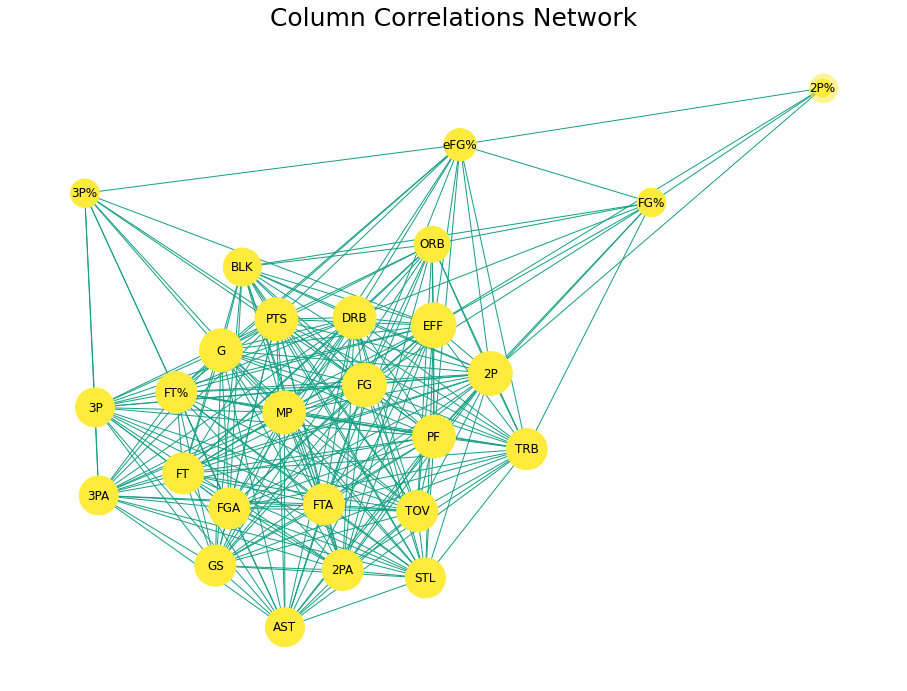

In [7]:
# Column Correlations Network
main_color = "#16a085"
strong_main_color = "#ffeb3b"
custom_colors = [strong_main_color, main_color]

df = players

thresh = 0.3
def correlation_network(data, corr_interval=[-0.9, 0.9], data_type="Train", node_color=custom_colors[1]):
    data = data
    corr = data.corr()
    corr = pd.melt(corr.reset_index(), id_vars="index")
    corr.columns = ["x", "y", "value"]
    high_corr = corr[((corr["value"] <= corr_interval[0]) | (corr["value"] >= corr_interval[1]))]
    high_corr = high_corr[(high_corr["value"] != 1)].reset_index(drop=True)
    sources = list(high_corr.x.unique())
    targets = list(high_corr.y.unique())
    plt.figure(figsize=(16, 12))
    g = nx.from_pandas_edgelist(high_corr, source="x", target="y") 
    layout = nx.spring_layout(g, iterations=50, k=0.6, seed=1337)
    target_size = [g.degree(t) * 80 for t in targets]
    nx.draw_networkx_nodes(g, layout, nodelist=targets, node_size=target_size, node_color=node_color)
    nx.draw_networkx_nodes(g, layout, nodelist=sources, node_color=node_color, node_size=800, alpha=0.5)
    nx.draw_networkx_edges(g, layout, width=1, edge_color=custom_colors[1])
    target_dict = dict(zip(targets, targets))
    nx.draw_networkx_labels(g, layout, labels=target_dict)
    plt.axis("off")
    plt.title(f"Column Correlations Network", fontsize=25)
    plt.show()
correlation_network(data=df, corr_interval=[-thresh, thresh], data_type="Train", node_color=custom_colors[0])

<AxesSubplot:xlabel='Pos', ylabel='PTS'>

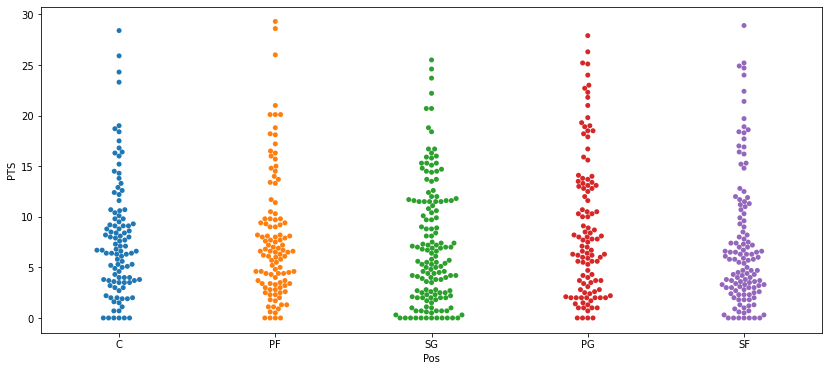

In [8]:
# points-position relation
plt.figure(figsize=(14,6))
sns.swarmplot(x=players["Pos"],
              y=players["PTS"])

In [9]:
# points mean per position
print("Points mean C: " + str(round(players_C.PTS.mean())))
print("Points mean PG: " + str(round(players_PG.PTS.mean())))
print("Points mean SG: " + str(round(players_SG.PTS.mean())))
print("Points mean PF: " + str(round(players_PF.PTS.mean())))
print("Points mean SF: " + str(round(players_SF.PTS.mean())))

Points mean C: 8
Points mean PG: 9
Points mean SG: 7
Points mean PF: 8
Points mean SF: 7


<AxesSubplot:xlabel='Pos', ylabel='EFF'>

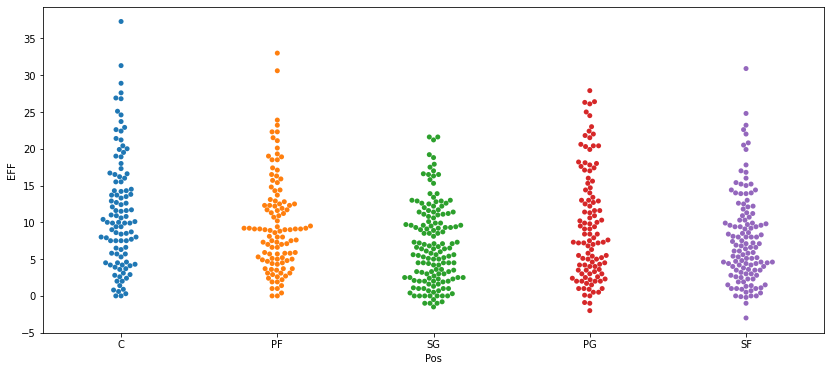

In [10]:
# efficiency-position relation
plt.figure(figsize=(14,6))
sns.swarmplot(x=players["Pos"],
              y=players["EFF"])

In [11]:
# efficiency mean per position
print("Efficiency mean C: " + str(round(players_C.EFF.mean())))
print("Efficiency mean PG: " + str(round(players_PG.EFF.mean())))
print("Efficiency mean SG: " + str(round(players_SG.EFF.mean())))
print("Efficiency mean PF: " + str(round(players_PF.EFF.mean())))
print("Efficiency mean SF: " + str(round(players_SF.EFF.mean())))

Efficiency mean C: 12
Efficiency mean PG: 10
Efficiency mean SG: 7
Efficiency mean PF: 10
Efficiency mean SF: 8


Mean points contribution of each position is almost equal.<br>
The importance of each position can be observed when position based efficiency calculated.<br>
Mean efficiencies differ by more than 10% between positions.

<AxesSubplot:xlabel='Age', ylabel='PTS'>

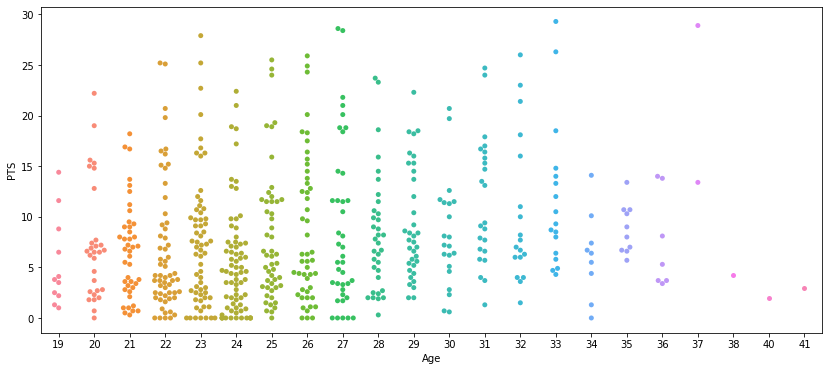

In [12]:
# points-age relation
plt.figure(figsize=(14,6))
sns.swarmplot(x=players["Age"],
              y=players["PTS"])

There are only four players older than 30 with +25 points. These are:

In [13]:
print(players.Player[(players.Age>=30) & (players.PTS>=25)])

Rk
123    Stephen Curry
131    DeMar DeRozan
150     Kevin Durant
266     LeBron James
Name: Player, dtype: object


In [14]:
players.Age.describe().round(decimals=1)

count    590.0
mean      25.8
std        4.2
min       19.0
25%       23.0
50%       25.0
75%       28.0
max       41.0
Name: Age, dtype: float64

Youngest player is 19 while the oldest is 41 years old.<br>
Player age has a mean of 25.8 with a standard deviation of 4.2.

# 6. Finding Future NBA Superstars
Gained a lot of data insight from above work.<br>
Let's classify and make a list of future superstars.<br>
I'll use mean age, points and efficiency values to list future NBA superstars.

In [15]:
Cs = pd.DataFrame(players_C.Player[(players_C.Age<=23)&(players_C.PTS>=10)&(players_C.EFF>=12)]).rename(columns={"Player": "Centers"}).reset_index(drop=True)
PGs = pd.DataFrame(players_PG.Player[(players_PG.Age<=23)&(players_PG.PTS>=10)&(players_PG.EFF>=12)]).rename(columns={"Player": "Point Guards"}).reset_index(drop=True)
SGs = pd.DataFrame(players_SG.Player[(players_SG.Age<=23)&(players_SG.PTS>=10)&(players_SG.EFF>=12)]).rename(columns={"Player": "Shooting Guards"}).reset_index(drop=True)
PFs = pd.DataFrame(players_PF.Player[(players_PF.Age<=23)&(players_PF.PTS>=10)&(players_PF.EFF>=12)]).rename(columns={"Player": "Power Forwards"}).reset_index(drop=True)
SFs = pd.DataFrame(players_SF.Player[(players_SF.Age<=23)&(players_SF.PTS>=10)&(players_SF.EFF>=12)]).rename(columns={"Player": "Small Forwards"}).reset_index(drop=True)

future = pd.concat([Cs, PGs, SGs, PFs, SFs], axis=1, join="outer")
future

,Centers,Point Guards,Shooting Guards,Power Forwards,Small Forwards
0,Jarrett Allen,Cole Anthony,Hamidou Diallo,Scottie Barnes,Desmond Bane
1,Deandre Ayton,LaMelo Ball,Anthony Edwards,Miles Bridges,RJ Barrett
2,Mo Bamba,Cade Cunningham,Josh Giddey,Jaren Jackson Jr.,Saddiq Bey
3,Wendell Carter Jr.,Luka Don?i?,Tyrese Haliburton,Evan Mobley,Luguentz Dort
4,NaN,Darius Garland,Tyler Herro,NaN,Keldon Johnson
5,NaN,Shai Gilgeous-Alexander,Kevin Huerter,NaN,Jayson Tatum
6,NaN,Tyrese Maxey,Malik Monk,NaN,Franz Wagner
7,NaN,Ja Morant,Jordan Poole,NaN,NaN
8,NaN,Kevin Porter Jr.,Anfernee Simons,NaN,NaN
9,NaN,Trae Young,Gary Trent Jr.,NaN,NaN


# 7. Conclusion
Classification limits are:
* Age <= 23
* Points per game >= 10
* Efficiency per game >= 12

So many guards with bright future: LaMelo Ball, Trae Young, Luka Doncic etc.<br>
Looks like the dominance of the guards will continue...